# Analysis of Covertypedataset from the UCI Machine Learning Repository.

In [16]:
import pandas as pd
import math
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import StringLookup
from matplotlib import pyplot as plt

Importing Dataset and Preprocessing it

In [17]:
data_url = (
    "https://archive.ics.uci.edu/ml/machine-learning-databases/covtype/covtype.data.gz"
)
raw_data = pd.read_csv(data_url, header=None)
print(f"Dataset shape: {raw_data.shape}")
display(raw_data.head())
display(raw_data.shape)

Dataset shape: (581012, 55)


,0,1,2,3,4,5,6,7,8,9,...,45,46,47,48,49,50,51,52,53,54
0,2596,51,3,258,0,510,221,232,148,6279,...,0,0,0,0,0,0,0,0,0,5
1,2590,56,2,212,-6,390,220,235,151,6225,...,0,0,0,0,0,0,0,0,0,5
2,2804,139,9,268,65,3180,234,238,135,6121,...,0,0,0,0,0,0,0,0,0,2
3,2785,155,18,242,118,3090,238,238,122,6211,...,0,0,0,0,0,0,0,0,0,2
4,2595,45,2,153,-1,391,220,234,150,6172,...,0,0,0,0,0,0,0,0,0,5


(581012, 55)

In [18]:
# Giving tag name for different soil types and widerness areas
soil_type_values = [f"soil_type_{idx+1}" for idx in range(40)]
wilderness_area_values = [f"area_type_{idx+1}" for idx in range(4)]

# Mapping 4 binary columns to wilderness_area_values
wilderness_area = raw_data.loc[:,10:13].apply(
    lambda x: wilderness_area_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)

# Mapping 40 binary columns to soil_type_values
soil_type = raw_data.loc[:,14:53].apply(
    lambda x: soil_type_values[0::1][x.to_numpy().nonzero()[0][0]], axis=1
)


In [19]:
# Giving Title to every Features

# Feature Name
Feature = [
    "Elevation",
    "Aspect",
    "Slope",
    "Horizontal_Distance_To_Hydrology",
    "Vertical_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Hillshade_3pm",
    "Horizontal_Distance_To_Fire_Points",
    "Wilderness_Area",
    "Soil_Type",
    "Cover_Type",
]

# Combining all features into a single dataset
data = pd.concat(
    [raw_data.loc[:,0:9], wilderness_area,soil_type,raw_data.loc[:,54]],
    axis=1,
    ignore_index=True
)
data.columns=Feature;

data["Cover_Type"] = data["Cover_Type"]-1
print(f"Dataset shape: {data.shape}")
data.head().T

Dataset shape: (581012, 13)


,0,1,2,3,4
Elevation,2596,2590,2804,2785,2595
Aspect,51,56,139,155,45
Slope,3,2,9,18,2
Horizontal_Distance_To_Hydrology,258,212,268,242,153
Vertical_Distance_To_Hydrology,0,-6,65,118,-1
Horizontal_Distance_To_Roadways,510,390,3180,3090,391
Hillshade_9am,221,220,234,238,220
Hillshade_Noon,232,235,238,238,234
Hillshade_3pm,148,151,135,122,150
Horizontal_Distance_To_Fire_Points,6279,6225,6121,6211,6172


Splitting Dataset into Train and Test

In [20]:
train_splits = []
test_splits = []

# Splitting based on target variable
for _, group_data in data.groupby("Cover_Type"):
    random_selection = np.random.rand(len(group_data.index)) <= 0.85
    train_splits.append(group_data[random_selection])
    test_splits.append(group_data[~random_selection])

train_data = pd.concat(train_splits).sample(frac=1).reset_index(drop=True)
test_data = pd.concat(test_splits).sample(frac=1).reset_index(drop=True)

print(f"Train size: {len(train_data.index)}")
print(f"Test size: {len(test_data.index)}")

Train size: 493725
Test size: 87287


In [21]:
# Saving train and test data as CSV files
train_data_file = "train_data.csv"
test_data_file = "test_data.csv"

train_data.to_csv(train_data_file, index=False)
test_data.to_csv(test_data_file, index=False)

In [22]:
# Dataset MetaData

TARGET_FEATURE_NAME = "Cover_Type"
TARGET_FEATURE_LABELS = ["0", "1", "2", "3", "4", "5", "6"]
NUMERIC_FEATURE_NAMES = [
    "Aspect",
    "Elevation",
    "Hillshade_3pm",
    "Hillshade_9am",
    "Hillshade_Noon",
    "Horizontal_Distance_To_Fire_Points",
    "Horizontal_Distance_To_Hydrology",
    "Horizontal_Distance_To_Roadways",
    "Slope",
    "Vertical_Distance_To_Hydrology",
]

CATEGORICAL_FEATURES_WITH_VOCABULARY = {
    "Soil_Type": list(data["Soil_Type"].unique()),
    "Wilderness_Area": list(data["Wilderness_Area"].unique()),
}

CATEGORICAL_FEATURE_NAMES = list(CATEGORICAL_FEATURES_WITH_VOCABULARY.keys())

FEATURE_NAMES = NUMERIC_FEATURE_NAMES + CATEGORICAL_FEATURE_NAMES

COLUMN_DEFAULTS = [
    [0] if feature_name in NUMERIC_FEATURE_NAMES + [TARGET_FEATURE_NAME] else ["NA"]
    for feature_name in Feature
]

NUM_CLASSES = len(TARGET_FEATURE_LABELS)

In [23]:
# Parameter Values
lr = 0.001
dr = 0.1
batch_size = 265
num_epochs = 50
hidden_units = [32, 32]

In [24]:
# Function to retrieve data from CSV
def get_dataset_from_csv(csv_file_path, batch_size, shuffle=False):

    dataset = tf.data.experimental.make_csv_dataset(
        csv_file_path,
        batch_size=batch_size,
        column_names=Feature,
        column_defaults=COLUMN_DEFAULTS,
        label_name=TARGET_FEATURE_NAME,
        num_epochs=1,
        header=True,
        shuffle=shuffle,
    )
    return dataset.cache()

In [25]:
# Function to One-Hot Encoding or embedding Categorical variables 
def encode_inputs(inputs, use_embedding=False):
    encoded_features = []
    for feature_name in inputs:
        if feature_name in CATEGORICAL_FEATURE_NAMES:
            vocabulary = CATEGORICAL_FEATURES_WITH_VOCABULARY[feature_name]

            lookup = StringLookup(
                vocabulary=vocabulary,
                mask_token=None,
                num_oov_indices=0,
                output_mode="int" if use_embedding else "binary",
            )
            if use_embedding:
                # Convert the string input values into integer indices.
                encoded_feature = lookup(inputs[feature_name])
                embedding_dims = int(math.sqrt(len(vocabulary)))
                # Create an embedding layer with the specified dimensions.
                embedding = layers.Embedding(
                    input_dim=len(vocabulary), output_dim=embedding_dims
                )
                # Convert the index values to embedding representations.
                encoded_feature = embedding(encoded_feature)
            else:
                # Convert the string input values into a one hot encoding.
                encoded_feature = lookup(tf.expand_dims(inputs[feature_name], -1))
        else:
            # Use the numerical features as-is.
            encoded_feature = tf.expand_dims(inputs[feature_name], -1)

        encoded_features.append(encoded_feature)

    all_features = layers.concatenate(encoded_features)
    return all_features

In [26]:
# Function to create Inputs for Models
def create_model_inputs():
    inputs = {}
    for feature_name in FEATURE_NAMES:
        if feature_name in NUMERIC_FEATURE_NAMES:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.float32
            )
        else:
            inputs[feature_name] = layers.Input(
                name=feature_name, shape=(), dtype=tf.string
            )
    return inputs

In [31]:
# Function to Compile, Fit the Model with the dataset and Evaluate it
def run_experiment(model):
    opt=keras.optimizers.Adam(learning_rate=lr)
    # Compiling
    model.compile(optimizer=opt, loss="SparseCategoricalCrossentropy",metrics=["acc"])

    # Loading Train and Test Dataset
    train_dataset = get_dataset_from_csv(train_data_file, batch_size, shuffle=True)
    test_dataset = get_dataset_from_csv(test_data_file, batch_size)

    # Fitting the Dataset
    history = model.fit(train_dataset, epochs=num_epochs)

    _, accuracy = model.evaluate(test_dataset, verbose=0)

    print(f"Test accuracy: {round(accuracy * 100, 2)}%")

In [32]:
# # model1 = keras.Sequential()
# lr = 0.001
# dr = 0.1
# batch_size = 265
# num_epochs = 50
# hidden_units = [32, 32]

# inputs = create_model_inputs()
# features = encode_inputs(inputs)

# for units in hidden_units:
#     features = layers.Dense(units)(features)
#     features = layers.BatchNormalization()(features)
#     features = layers.ReLU()(features)
#     features = layers.Dropout(dr)(features)

# outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
# model1 = keras.Model(inputs=inputs, outputs=outputs)
# # inputs= create_model_inputs()

# # features = encode_inputs(inputs)

# # hidden1 = layers.Dense(32,activation="relu",name="HiddenLayer1")
# # h1 = hidden1(features)

# # hidden2 = layers.Dense(32,activation="relu",name="HiddenLayer2")
# # h1 = hidden2(h1)

# # outputs = layers.Dense(6,activation="softmax")(h1)

# # model1 = keras.Model(inputs=inputs, outputs=outputs, name="Model1");
# # model1.add(layers.BatchNormalization())
# # model1.add(layers.Dense(32, activation="relu",name="HiddenLayer1"))
# # model1.add(layers.Dense(32, activation="relu",name="HiddenLayer2"))
# # model1.add(layers.Dense(6, activation="softmax",name="OutputLayer"))

# display(model1.summary())

# display(tf.keras.utils.plot_model(model1,
#                           show_shapes=True, 
#                           show_layer_activations=True, 
#                           show_dtype=True,
#                           show_layer_names=True,
#                           rankdir="LR" ))
# opt = keras.optimizers.Adam(learning_rate=lr)
# model1.compile(loss="SparseCategoricalCrossentropy",optimizer="Adam",metrics=["acc"])


## Model 1<br>
Create  a  multi-layer  feed-forward  network,  where  the  categorical  features  are  one-hot encoded.

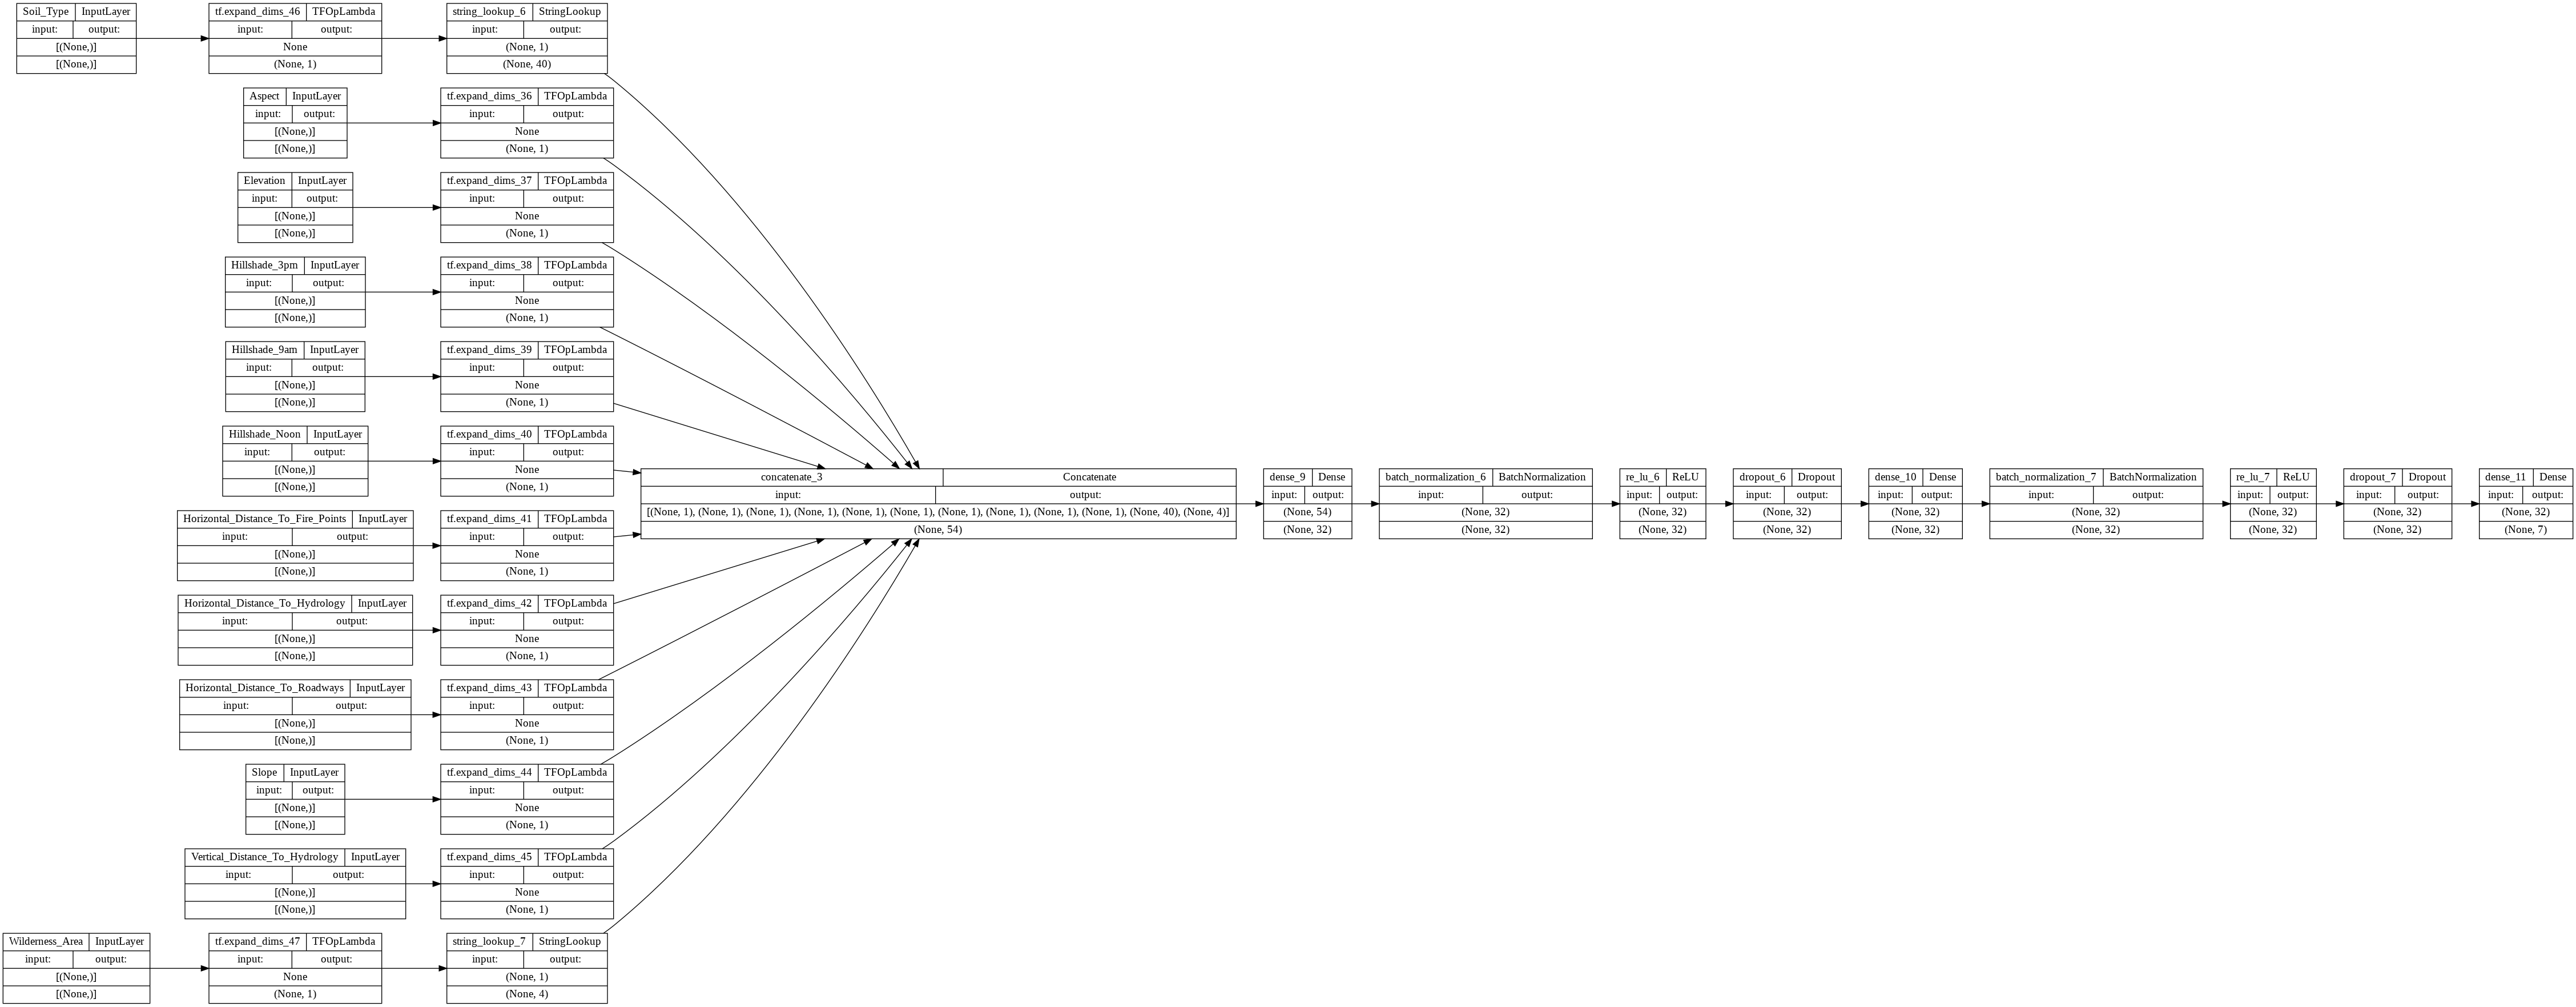

In [33]:
# Building a multi-layer feed-forward network
inputs = create_model_inputs()
features = encode_inputs(inputs)

for units in hidden_units:
    features = layers.Dense(units)(features)
    features = layers.BatchNormalization()(features)
    features = layers.ReLU()(features)
    features = layers.Dropout(dr)(features)

outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(features)
model1 = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model1, show_shapes=True, rankdir="LR")

In [34]:
run_experiment(model1)

Epoch 1/50
1864/1864 [==============================] - 14s 7ms/step - loss: 0.7667 - acc: 0.6801
Epoch 2/50
1864/1864 [==============================] - 10s 5ms/step - loss: 0.6662 - acc: 0.7113
Epoch 3/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.6424 - acc: 0.7229
Epoch 4/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.6224 - acc: 0.7314
Epoch 5/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.6068 - acc: 0.7389
Epoch 6/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5954 - acc: 0.7439
Epoch 7/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5895 - acc: 0.7462
Epoch 8/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5840 - acc: 0.7488
Epoch 9/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5785 - acc: 0.7513
Epoch 10/50
1864/1864 [==============================] - 9s 5ms/step - loss: 0.5754 - acc: 0.7525
Epoch 11/50
1864/1864 [===

## Model2
<br>Create a Wide & Deep modelwhere the wide part of the model a linear model, while the deep   part   of   the   model   is   a   multi-layer   feed-forward   network.

/usr/local/lib/python3.7/dist-packages/numpy/core/numeric.py:2446: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  return bool(asarray(a1 == a2).all())


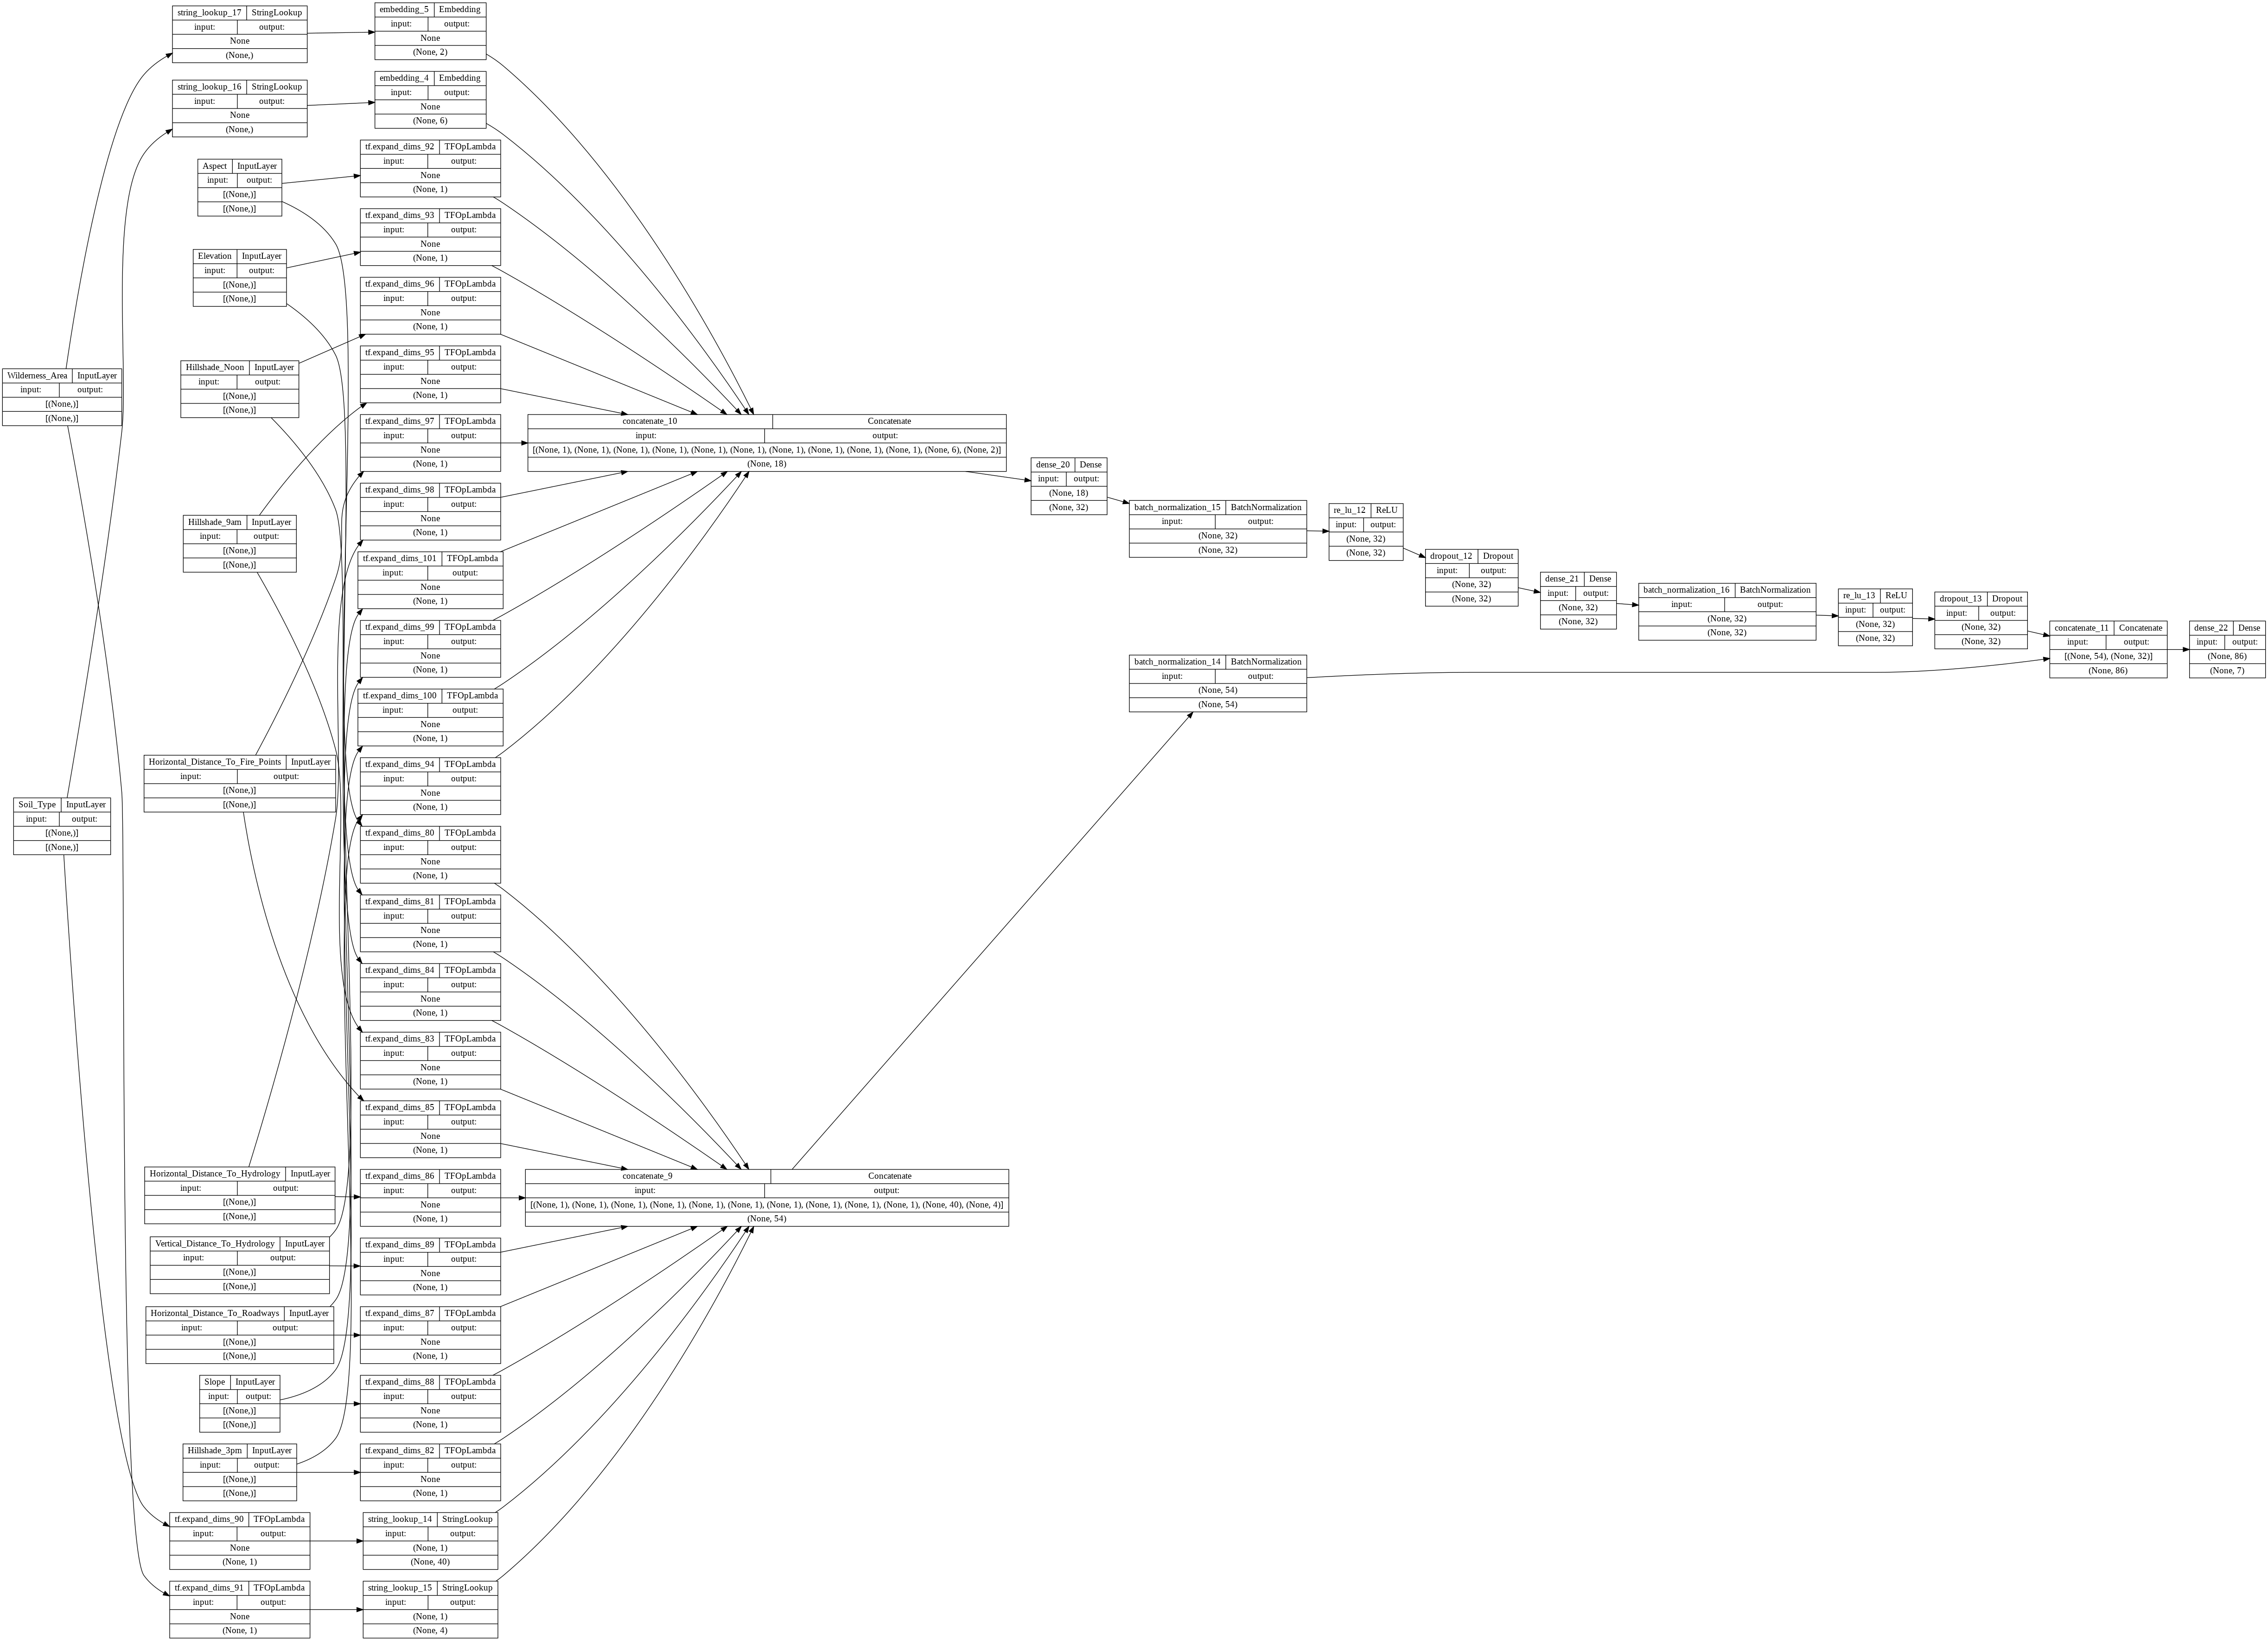

In [39]:
# Building Wide and Deep Neural Network
inputs = create_model_inputs()
wide = encode_inputs(inputs)
wide = layers.BatchNormalization()(wide)

deep = encode_inputs(inputs, use_embedding=True)
for units in hidden_units:
    deep = layers.Dense(units)(deep)
    deep = layers.BatchNormalization()(deep)
    deep = layers.ReLU()(deep)
    deep = layers.Dropout(dr)(deep)

merged = layers.concatenate([wide, deep])
outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
model2 = keras.Model(inputs=inputs, outputs=outputs)

keras.utils.plot_model(model2, show_shapes=True, rankdir="LR")

In [36]:
run_experiment(model2)

Epoch 1/50
1864/1864 [==============================] - 19s 10ms/step - loss: 0.7036 - acc: 0.7068
Epoch 2/50
1864/1864 [==============================] - 15s 8ms/step - loss: 0.6033 - acc: 0.7381
Epoch 3/50
1864/1864 [==============================] - 16s 9ms/step - loss: 0.5869 - acc: 0.7449
Epoch 4/50
1864/1864 [==============================] - 13s 7ms/step - loss: 0.5756 - acc: 0.7491
Epoch 5/50
1864/1864 [==============================] - 14s 7ms/step - loss: 0.5682 - acc: 0.7530
Epoch 6/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5610 - acc: 0.7559
Epoch 7/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5553 - acc: 0.7589
Epoch 8/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5507 - acc: 0.7609
Epoch 9/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5459 - acc: 0.7633
Epoch 10/50
1864/1864 [==============================] - 16s 8ms/step - loss: 0.5411 - acc: 0.7657
Epoch 11/50
1864/1

## Model3
<br>
Create a Deep & Cross model.

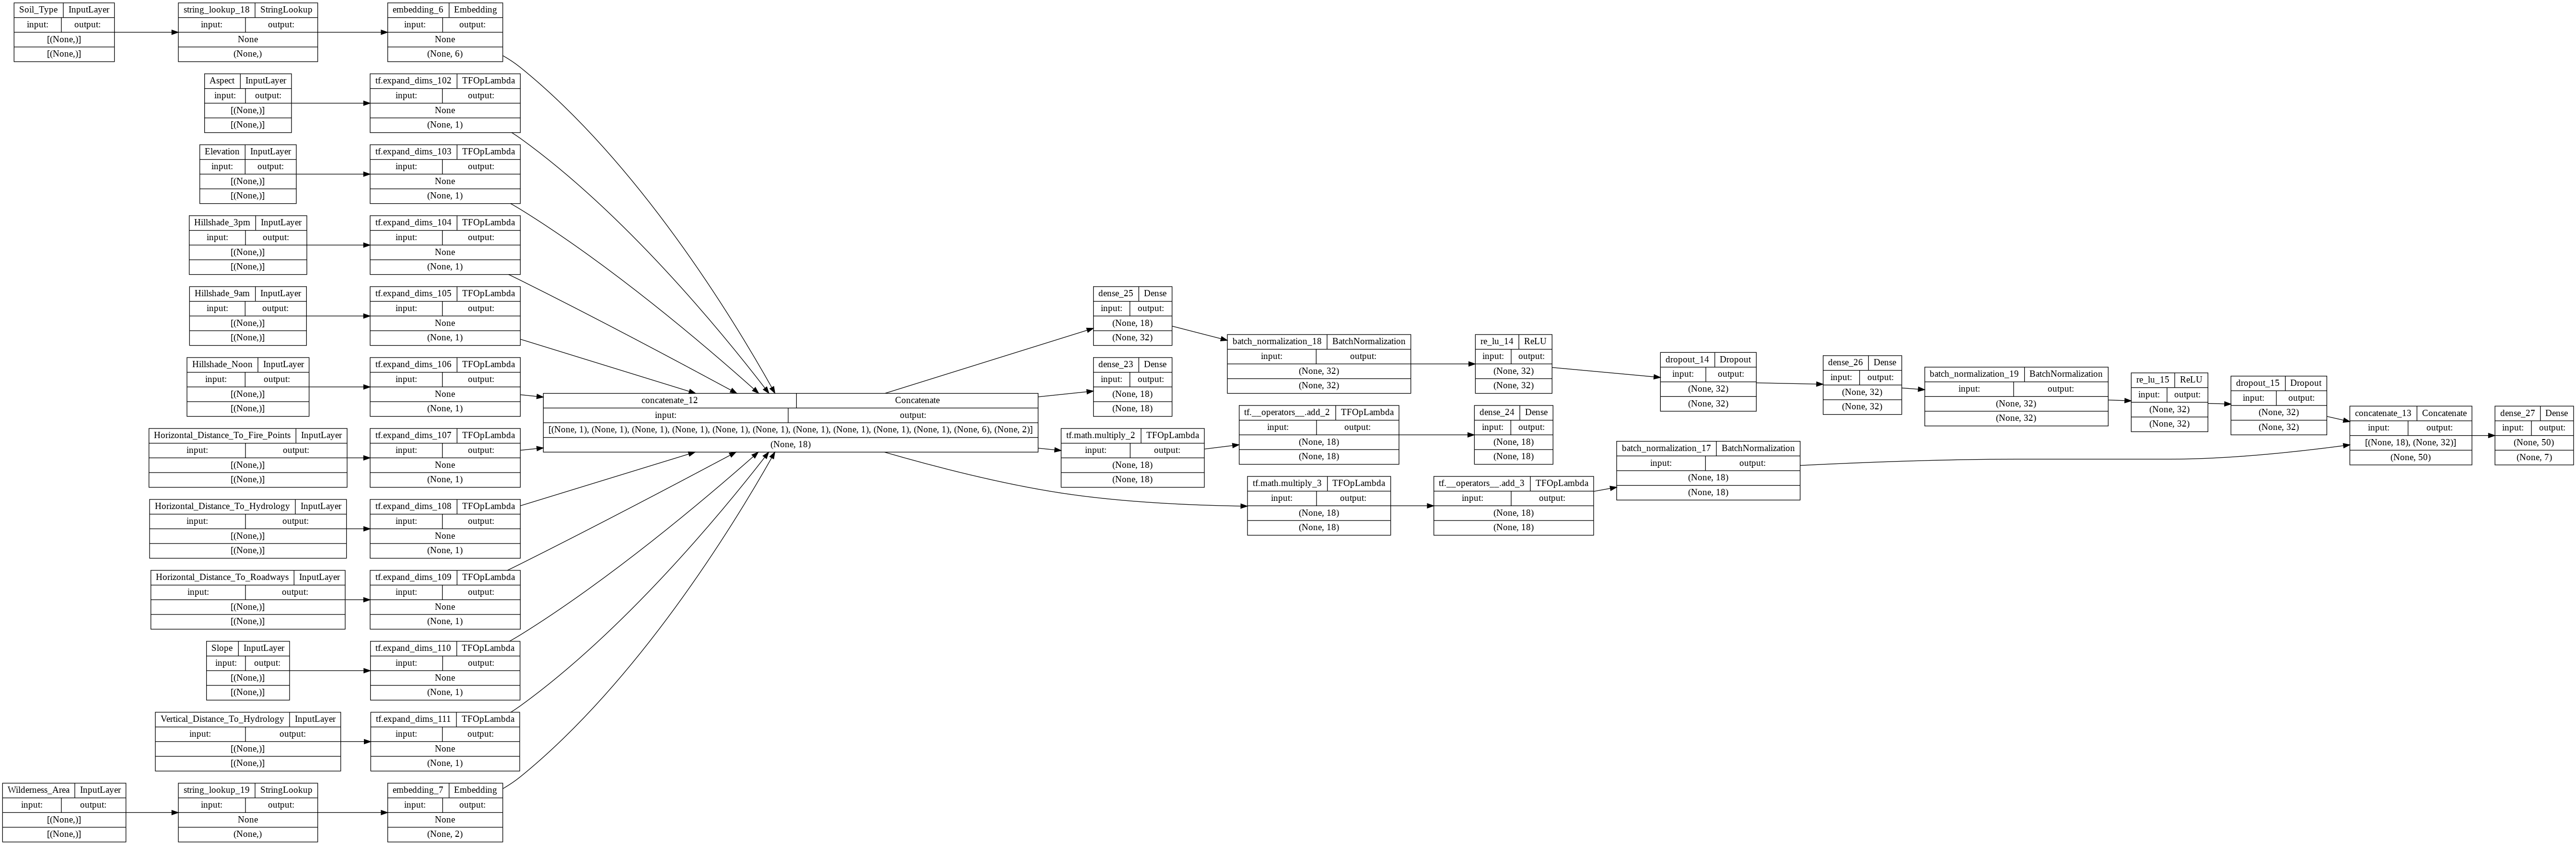

In [40]:
# Building a Deep and Cross Model
inputs = create_model_inputs()
x0 = encode_inputs(inputs, use_embedding=True)

cross = x0
for _ in hidden_units:
    units = cross.shape[-1]
    x = layers.Dense(units)(cross)
    cross = x0 * x + cross
cross = layers.BatchNormalization()(cross)

deep = x0
for units in hidden_units:
    deep = layers.Dense(units)(deep)
    deep = layers.BatchNormalization()(deep)
    deep = layers.ReLU()(deep)
    deep = layers.Dropout(dr)(deep)

merged = layers.concatenate([cross, deep])
outputs = layers.Dense(units=NUM_CLASSES, activation="softmax")(merged)
model3 = keras.Model(inputs=inputs, outputs=outputs)
keras.utils.plot_model(model3, show_shapes=True, rankdir="LR")

In [41]:
run_experiment(model3)

Epoch 1/50
1864/1864 [==============================] - 18s 9ms/step - loss: 0.6904 - acc: 0.7135
Epoch 2/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5906 - acc: 0.7440
Epoch 3/50
1864/1864 [==============================] - 11s 6ms/step - loss: 0.5714 - acc: 0.7517
Epoch 4/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5606 - acc: 0.7561
Epoch 5/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5529 - acc: 0.7596
Epoch 6/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5474 - acc: 0.7618
Epoch 7/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5433 - acc: 0.7630
Epoch 8/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5396 - acc: 0.7644
Epoch 9/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5367 - acc: 0.7661
Epoch 10/50
1864/1864 [==============================] - 12s 6ms/step - loss: 0.5344 - acc: 0.7673
Epoch 11/50
1864/18

## Conclusion
<table>
<tr>
  <th>Test Accuracy</th>
  <td></td>
</tr>
<tr>
  <th>Model-1</th>
  <td>75.57%</td>
</tr>
<tr>
  <th>Model-2</th>
  <td>79.93%</td>
</tr>
<tr>
  <th>Model-3</th>
  <td>80.41%</td>
</tr>

Model-2 and Model-3 has the More Accuracy compared to Model-1.
Hence a Deep and Cross or Deep and Wide Model fit better for this dataset.